/Users/hassan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Mean Absolute Error on Test Set: 10.791403879235963


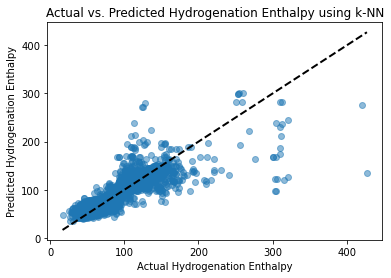

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Read the cleaned CSV file
file_path = 'gdb9_G4MP2_withdata_hydrogenation_clean.csv'
data = pd.read_csv(file_path)

# Function to compute custom molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    unsaturated_bonds = sum(1 for bond in mol.GetBonds() if bond.GetBondType() != Chem.BondType.SINGLE)
    sp3, sp2, sp = 0, 0, 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'C':
            hybridization = atom.GetHybridization()
            if hybridization == Chem.HybridizationType.SP3:
                sp3 += 1
            elif hybridization == Chem.HybridizationType.SP2:
                sp2 += 1
            elif hybridization == Chem.HybridizationType.SP:
                sp += 1
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumHeteroatoms(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NHOHCount(mol),
        Descriptors.NOCount(mol),
        Descriptors.RingCount(mol),
        unsaturated_bonds,
        sp3, sp2, sp
    ]

# Apply the compute_descriptors function to the unsat_SMILE column
X = data['unsat_SMILE'].apply(compute_descriptors)
X = pd.DataFrame(X.tolist()) # Convert the result into a DataFrame

y = data['delta_H']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a k-NN model
model = KNeighborsRegressor(n_neighbors=5) # You can experiment with the number of neighbors
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on Test Set: {mae}')

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Hydrogenation Enthalpy')
plt.ylabel('Predicted Hydrogenation Enthalpy')
plt.title('Actual vs. Predicted Hydrogenation Enthalpy using k-NN')
plt.show()
